In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import glob
import pandas as pd
plt.rcParams['figure.figsize'] = [12,10]

In [29]:
mode_dir = '/Users/davies/Projects/KeplerGold/Reprocessed/'
sfiles = glob.glob(mode_dir + '*.csv')[:100]
dfs = [pd.read_csv(n) for n in sfiles]
dfs = [n.sort_values(by='f0') for n in dfs]

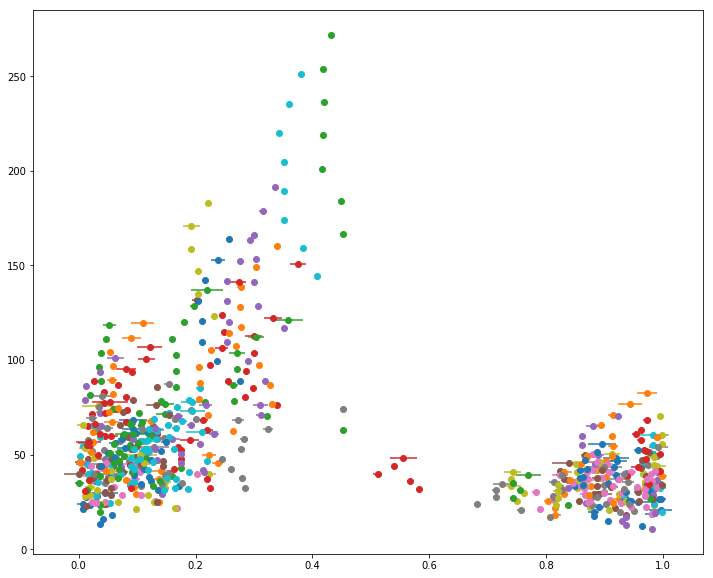

In [30]:
fig, ax = plt.subplots()
dnus = np.array([np.median(np.diff(np.sort(n.f0))) for n in dfs])
for idx, df in enumerate(dfs):
        f_err = df.f0_err[np.argsort(df.f0)]
        f = np.sort(df.f0)
        ax.errorbar(f % dnus[idx] / dnus[idx], f, xerr=f_err/dnus[idx], fmt='o')


In [61]:
code = '''
functions {
    real asy(real n, real epsilon, real alpha, real dnu, real numax){
        real nmax = numax / dnu - epsilon;
        return (n + epsilon + alpha / 2 * (n - nmax)^2) * dnu;
    }
    real glitch(real f, real A, real dnu, real numax, real G, real phi){
        return A * dnu * cos(2.0 * 3.14 * (f - numax) / G / dnu + phi);
    } 
}
data {
    int<lower = 0> N;
    real n[N];
    real f[N];
    real ferr[N];
    real dnu_guess;
    real numax_guess;
}
parameters {
    real<lower = 0.5, upper = 1.5> epsilon;
    real alpha;
    real dnu;
    real numax;
    real<lower = 0> A;
    real<lower = 0> G;
    real<lower = 0, upper = 2*3.14> phi;
}
model {
    real tmp[N];
    for (i in 1:N){
        tmp[i] = asy(n[i], epsilon, alpha, dnu, numax) + glitch(f[i], A, dnu, numax, G, phi);
    }
    tmp ~ normal(f, ferr);
    alpha ~ normal(0.015 * dnu^-0.32, 0.3);
    epsilon ~ normal(0.6 + 0.6 * log(dnu), 0.1);
    numax ~ normal(numax_guess, 1.0);
    dnu ~ normal(dnu_guess, 0.5);
}
'''
sm = pystan.StanModel(model_code=code, model_name='second_asy')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL second_asy_20482bf789dfd36c8aabc23619f27767 NOW.


<Container object of 3 artists>

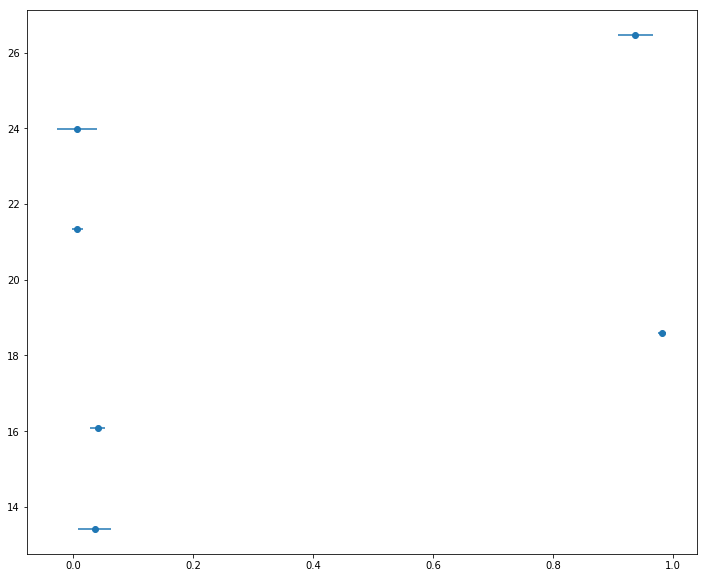

In [65]:
i=0
df = dfs[i]
dnu = dnus[i]
numax = np.mean(df.f0)
flow = np.min(df.f0)
n = np.arange(int(flow / dnu), int(flow / dnu) + len(df), 1)
fig, ax = plt.subplots()
ax.errorbar(df.f0 % dnu / dnu, df.f0, xerr=df.f0_err, fmt='o')

/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


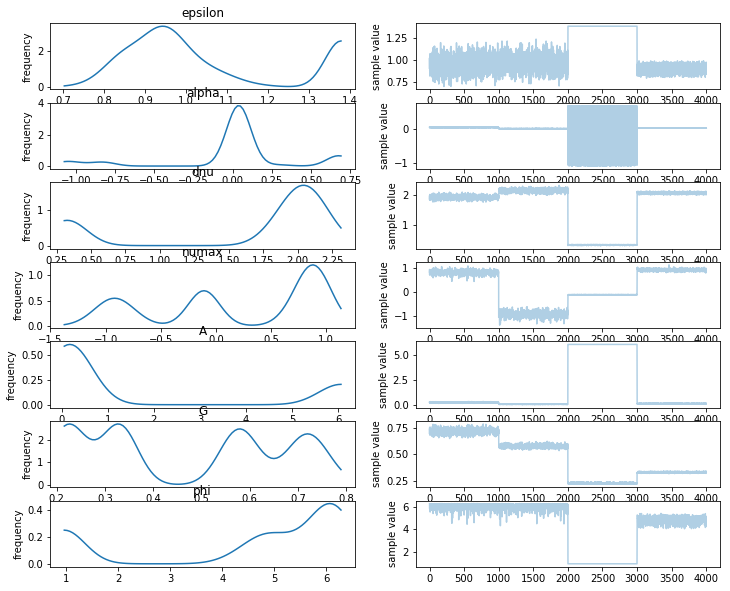

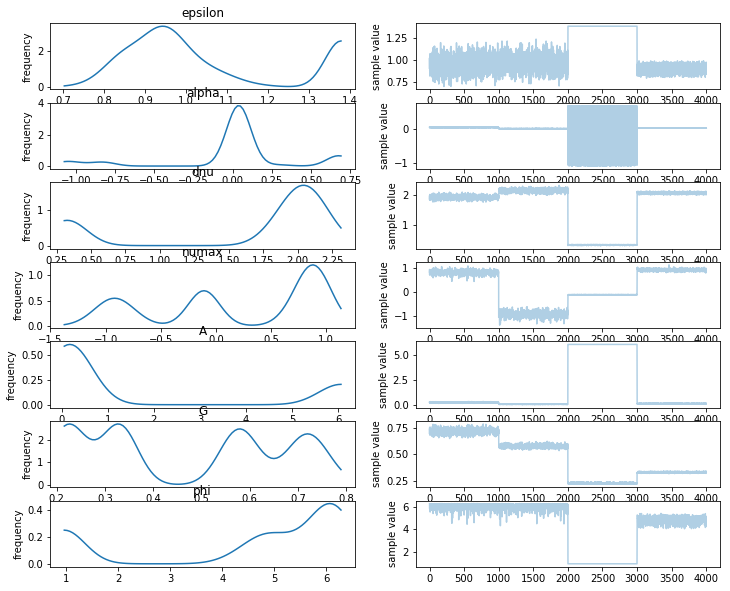

In [66]:
dat = {'N': len(df),
       'n': n,
       'f': df.f0.values,
       'ferr': df.f0_err.values,
       'dnu_guess': dnu,
       'numax_guess': numax}
fit = sm.sampling(data=dat, iter=2000, chains=4)
fit.plot()

In [68]:
print(fit)

Inference for Stan model: second_asy_20482bf789dfd36c8aabc23619f27767.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
epsilon   1.05    0.14    0.2   0.81   0.91   0.97   1.31   1.38      2   3.26
alpha     0.01    0.13    0.4  -1.07   0.02   0.04   0.06   0.69     10   2.72
dnu       1.61    0.53   0.75   0.32   0.98   2.01   2.09   2.22      2   18.4
numax     0.18    0.53   0.75  -1.06  -0.39   0.17   0.88   0.99      2  11.06
A         1.65     1.8   2.55   0.08   0.12   0.21    3.5   6.06      2 132.83
G         0.46    0.14    0.2   0.22   0.27   0.44   0.64   0.75      2  14.52
phi       4.46    1.48   2.09   0.97   2.36   5.27   6.11   6.27      2  10.97
lp__    -1.9e6   2.1e6  5.1e6 -1.8e7 -4.2e5 -219.3 -192.9 -190.6      6   3.14

Samples were drawn using NUTS at Tue Feb 20 21:43:59 2018.
For each parameter, n_eff is a crude mea